In [106]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import glob
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
# ファイルの一覧を取得
files = glob.glob("data/classification/*/*.txt")
print (files[:10]) # 最初の10件表示

['data/classification/livedoor-homme/livedoor-homme-4608109.txt', 'data/classification/livedoor-homme/livedoor-homme-5695247.txt', 'data/classification/livedoor-homme/livedoor-homme-4768050.txt', 'data/classification/livedoor-homme/livedoor-homme-5608639.txt', 'data/classification/livedoor-homme/livedoor-homme-5460086.txt', 'data/classification/livedoor-homme/livedoor-homme-5695257.txt', 'data/classification/livedoor-homme/livedoor-homme-5442194.txt', 'data/classification/livedoor-homme/livedoor-homme-6403291.txt', 'data/classification/livedoor-homme/livedoor-homme-6393628.txt', 'data/classification/livedoor-homme/livedoor-homme-4883137.txt']


In [16]:
# ファイル読み込みのテスト
with open(files[0], "r") as f:
    for line in f:
        print (line)

http://news.livedoor.com/article/detail/4608109/

2010-02-25T19:00:00+0900

グローバルで差をつけろ！HYBRID W-ZERO3【新生活特集】

日本のケータイは、海外の主流と異なり独自進化したことからガラパゴスともいわれています。



特に出張や旅行で海外へ渡航した際に、国内のケータイがそのまま使えないことは、ビジネスシーンだけでなく不自由さを感じるところです。もちろん、ローミングサービスで利用する方法もありますが、現地の通信料金よりも割高な利用料金が必要となります。



ほかにもSIMロックにより、同じW-CDMA方式ながらドコモとソフトバンクモバイル端末間でSIMを相互利用できなかったり、利用できても定額サービス対象外となったりと制約はまだ多いのが現状です。



こうした状況の中、これまでのケータイの制約を大きくクリアした端末が登場しました。

ウィルコムのHYBRID W-ZERO3です。



HYBRID W-ZERO3は、W-SIM型GSMモジュールに対応しており、海外で一般的なGSM方式のエリア内ならば、現地のSINカードを調達することで、ローミングしなくても現地の通信料金で通話ができる端末なのです。



このほかにも、「W-OAM typeG」対応のW-SIMによる高音質な通話、「W-CDMA(3.5G)」で下り最大7.2Mbps高速データ通信にも対応しており、国内での快適な利用ができます。



国内では、快適な高速通信でインターネット利用も仕事のメールも処理し、海外では現地のプリペイドSIMを使って現地通信料金で通話と、まさにスマートです。



グローバルな機能だけでなく、HYBRID W-ZERO3は本体もスマートです。

これまでウィルコムは、PCと同様のQWERTYキーボードの搭載にこだわってきましたが、HYBRID W-ZERO3では思い切って、QWERTYキーボードを廃して、ケータイと同じダイヤルキーを採用して薄型化しました。



■ダイヤルキーでスリムに！

HYBRID W-ZERO3には、これまでウィルコムスマートフォンの代名詞でもあったQWERTYキーボードを廃して、スライド式の10キーに変更されています。そのぶん、スマートな本体となってい

In [85]:
# 全ファイルをロード
# ついでに正解クラスと対応付け
X_texts = []
y = []
category_dict = {}
for file_path in files:
    class_name = file_path.split("/")[-2]
    y.append(category_dict.setdefault(class_name, len(category_dict)))
    with open(file_path, "r", encoding="utf-8") as f:
        text = ""
        for line in f:
            text += line
    X_texts.append(text)

In [98]:
# bow用の辞書を作成する
# 名詞のみを使う
mt = MeCab.Tagger("-Ochasen")
def make_vocab(texts, freq=10):
    """
    辞書を作成する
    texts:辞書を作るためのテキストのリスト
    freq:出現回数での足切りのための閾値
    """
    all_vocab = {} # 全ての単語用辞書
    vocab = {} # 最終的な辞書
    counter = {} # 出現回数カウント用
    for text in texts:
        lines = text.split("\n")
        for i, line in enumerate(lines):
            if i <= 2: continue # 1,2行目はメタ情報っぽいので除く
            mt.parse('')  # 文字コードの闇回避用
            res = mt.parseToNode(line)
            while res:
                infos = res.feature.split(",")
                if infos[0] == "名詞":
                    all_vocab.setdefault(res.surface, len(all_vocab))
                    counter[res.surface] = counter.get(res.surface, 0) + 1
                res = res.next

    idx = 0
    for k,v in all_vocab.items():
        if counter[k] >= freq:
            vocab[k] = idx
            idx += 1
    
    return vocab

In [101]:
def make_bow(text, vocab):
    """
    文章をbow形式に変換
    text:bow形式に変換したいテキスト
    vocab:使う単語をまとめた辞書
    """
    bow = [0 for _ in range(len(vocab))]
    lines = text.split("\n")
    for line in lines:
        res = mt.parseToNode(line)
        while res:  
            index = vocab.get(res.surface, -1)
            if index >= 0:
                bow[index] += 1
            res = res.next
            
    return bow

In [99]:
vocab = make_vocab(X_texts)

In [102]:
make_bow(X_texts[0] ,vocab)

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [103]:
X = []
for texts in X_texts:
    X.append(make_bow(texts, vocab))

In [107]:
X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [108]:
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
print (y_pred)

[5 8 7 ..., 1 4 4]


In [111]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category_dict))
    plt.xticks(tick_marks, category_dict, rotation=45)
    plt.yticks(tick_marks, category_dict)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[105   2   4   0   6   7   0   8   1]
 [  0 210   0   1   0   0   2   0   0]
 [  1   0 217   0   0   1   2   1   3]
 [  0   0   0 207   0   0   1   0   0]
 [  0   0   0   0 202   8   1   3   0]
 [  7   0   1   0   3 198   0   4   0]
 [  1  10   2   0   0   0 183   0   0]
 [  8   2   0   0   0   8   0 204   1]
 [  4   0  11   1   1   0   2   1 199]]


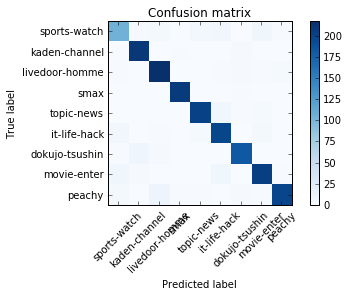

In [112]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)